In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

In [2]:
data_rnn = pd.read_csv("https://raw.githubusercontent.com/t0ccata/final-project-ml/main/archive/daily/AALI.csv")
data_rnn['timestamp'] = pd.to_datetime(data_rnn['timestamp'])
data_rnn.set_index('timestamp', inplace=True)
data_rnn.head()

,open,low,high,close,volume
timestamp,,,,,
2001-04-16,524,524,547,547,342131
2001-04-17,547,524,571,524,345804
2001-04-18,547,524,547,524,230361
2001-04-19,524,500,524,500,457574
2001-04-20,476,452,476,452,228262


In [3]:
data_rnn.isna().sum()

open      0
low       0
high      0
close     0
volume    0
dtype: int64

In [4]:
train_size = int(len(data_rnn) * 0.8)
data_train, data_test = data_rnn[:train_size], data_rnn[train_size:]

In [5]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train = scaler.fit_transform(data_train)
scaled_test = scaler.transform(data_test)

In [6]:
def create_sequences(data, seq_length):
    sequences, targets = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        targets.append(data[i + seq_length, 3])
    return np.array(sequences), np.array(targets)

seq_length = 60

In [7]:
X_train, y_train = create_sequences(scaled_train, seq_length)
X_test, y_test = create_sequences(scaled_test, seq_length)

In [8]:
train_val_split = int(len(X_train) * 0.8)
X_train_final, X_val = X_train[:train_val_split], X_train[train_val_split:]
y_train_final, y_val = y_train[:train_val_split], y_train[train_val_split:]

In [9]:
model = Sequential()
model.add(SimpleRNN(50, input_shape=(seq_length, X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(SimpleRNN(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(1))

In [10]:
model.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
history = model.fit(X_train_final, y_train_final, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
112/112 [==============================] - 8s 51ms/step - loss: 0.1034 - val_loss: 0.0020
Epoch 2/20
112/112 [==============================] - 4s 35ms/step - loss: 0.0244 - val_loss: 5.8973e-04
Epoch 3/20
112/112 [==============================] - 4s 36ms/step - loss: 0.0143 - val_loss: 4.2001e-04
Epoch 4/20
112/112 [==============================] - 4s 38ms/step - loss: 0.0096 - val_loss: 7.2457e-04
Epoch 5/20
112/112 [==============================] - 5s 42ms/step - loss: 0.0079 - val_loss: 0.0012
Epoch 6/20
112/112 [==============================] - 4s 36ms/step - loss: 0.0064 - val_loss: 7.4461e-04
Epoch 7/20
112/112 [==============================] - 4s 35ms/step - loss: 0.0054 - val_loss: 0.0021
Epoch 8/20
112/112 [==============================] - 5s 46ms/step - loss: 0.0044 - val_loss: 3.7260e-04
Epoch 9/20
112/112 [==============================] - 4s 34ms/step - loss: 0.0041 - val_loss: 2.8974e-04
Epoch 10/20
112/112 [==============================] - 4s 36ms/step

In [12]:
train_predictions = model.predict(X_train_final)
val_predictions = model.predict(X_val)
test_predictions = model.predict(X_test)

34/34 [==============================] - 0s 10ms/step


In [28]:
def inverse_transform(targets, predictions, scaler, original_data):

    targets_scaled = np.zeros((len(targets), original_data.shape[1]))
    predictions_scaled = np.zeros((len(predictions), original_data.shape[1]))


    targets_scaled[:, 3] = targets
    predictions_scaled[:, 3] = predictions.flatten()


    targets_actual = scaler.inverse_transform(targets_scaled)[:, 3]
    predictions_actual = scaler.inverse_transform(predictions_scaled)[:, 3]

    return targets_actual, predictions_actual

y_train_final_actual, train_predictions_actual = inverse_transform(y_train_final, train_predictions, scaler, data_train)
y_val_actual, val_predictions_actual = inverse_transform(y_val, val_predictions, scaler, data_train)
y_test_actual, test_predictions_actual = inverse_transform(y_test, test_predictions, scaler, data_train)

In [29]:
mse_train = mean_squared_error(y_train_final_actual, train_predictions_actual)
mape_train = mean_absolute_percentage_error(y_train_final_actual, train_predictions_actual)
r2_train = r2_score(y_train_final_actual, train_predictions_actual)


In [30]:
print(f'Normalized Data Metrics:')
print(f'MSE: {mse_train}')
print(f'MAPE: {mape_train}')
print(f'R2 Score: {r2_train}')

Normalized Data Metrics:
MSE: 245469.25022188705
MAPE: 0.03583150693590785
R2 Score: 0.9969853320799316


In [31]:
mse_val = mean_squared_error(y_val_actual, val_predictions_actual)
mape_val = mean_absolute_percentage_error(y_val_actual, val_predictions_actual)
r2_val = r2_score(y_val_actual, val_predictions_actual)

In [32]:
print(f'Validation Data Metrics:')
print(f'MSE: {mse_val}')
print(f'MAPE: {mape_val}')
print(f'R2 Score: {r2_val}')

Validation Data Metrics:
MSE: 259964.54565316992
MAPE: 0.02368049427015672
R2 Score: 0.9684293063900385


In [33]:
mse_test = mean_squared_error(y_test_actual, test_predictions_actual)
mape_test = mean_absolute_percentage_error(y_test_actual, test_predictions_actual)
r2_test = r2_score(y_test_actual, test_predictions_actual)

In [34]:
print(f'Test Data Metrics:')
print(f'MSE: {mse_test}')
print(f'MAPE: {mape_test}')
print(f'R2 Score: {r2_test}')

Test Data Metrics:
MSE: 122350.3425208398
MAPE: 0.027886489117244884
R2 Score: 0.9641082229423826


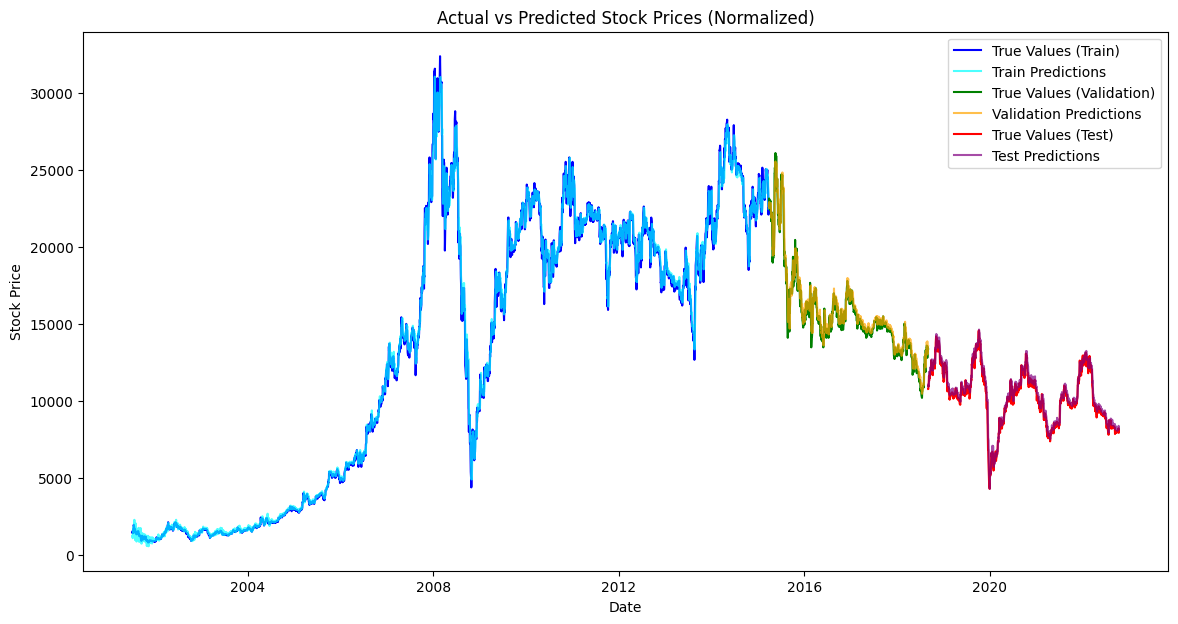

In [35]:
plt.figure(figsize=(14, 7))
plt.plot(data_train.index[seq_length:seq_length + len(y_train_final_actual)], y_train_final_actual, label='True Values (Train)', color='blue')
plt.plot(data_train.index[seq_length:seq_length + len(train_predictions_actual)], train_predictions_actual, label='Train Predictions', color='cyan', alpha=0.7)
plt.plot(data_train.index[seq_length + len(y_train_final_actual):seq_length + len(y_train_final_actual) + len(y_val_actual)], y_val_actual, label='True Values (Validation)', color='green')
plt.plot(data_train.index[seq_length + len(train_predictions_actual):seq_length + len(train_predictions_actual) + len(val_predictions_actual)], val_predictions_actual, label='Validation Predictions', color='orange', alpha=0.7)
plt.plot(data_test.index[:len(y_test_actual)], y_test_actual, label='True Values (Test)', color='red')
plt.plot(data_test.index[:len(test_predictions_actual)], test_predictions_actual, label='Test Predictions', color='purple', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Actual vs Predicted Stock Prices (Normalized)')
plt.show()